## Анализ вакансий сайта hh.ru

## Обработка данных

### Загрузка данных из источника

In [25]:
#%pip install pandas
#%pip install numpy
import sqlite3
import pandas as pd
import numpy as np

con = sqlite3.connect("..\db\hhvacancy.db")
cur = con.cursor()
vacancies_frame = pd.read_sql("""
SELECT 
    SalaryMiddleClear,
    CountersTotalResponses,
    ExperienceName,
    SalaryCurrency,
    KeySkills
FROM 
    VacancyFullInfo
WHERE 
    SalaryMiddleClear IS NOT NULL 
    AND CountersTotalResponses IS NOT NULL 
    AND ExperienceName IS NOT NULL;""", con)

### Исходные данные

In [26]:
vacancies_frame

,SalaryMiddleClear,CountersTotalResponses,ExperienceName,SalaryCurrency,KeySkills
0,185000.0,55,От 3 до 6 лет,RUR,None
1,95000.0,144,От 1 года до 3 лет,RUR,None
2,2500.0,137,От 3 до 6 лет,USD,"Laravel,PHP"
3,2500.0,102,От 3 до 6 лет,USD,"Laravel,PHP"
4,2500.0,118,От 3 до 6 лет,USD,"Laravel,PHP"
...,...,...,...,...,...
2377,90000.0,10,От 3 до 6 лет,RUR,"BGP,L2/L3-коммутация,Linux,Настройка сетевых п..."
2378,75000.0,167,От 3 до 6 лет,RUR,"CI/CD,Docker,HTTP,IMS,Linux,PyTest,Python,SIP,..."
2379,178350.0,228,От 1 года до 3 лет,RUR,Автотестирование интерфейсов
2380,70000.0,144,От 1 года до 3 лет,RUR,None


### Конвертация валюты заработной платы в рубли

In [27]:
#%pip install requests

In [28]:
# %load wallet_converter
import requests
from xml.etree import ElementTree as ET

def get_exchange_rates(date):
    url = f'https://www.cbr.ru/scripts/XML_daily.asp?date_req={date}'
    response = requests.get(url)
    response.raise_for_status()  # Проверка успешности запроса
    return response.content

def parse_exchange_rates(xml_data):
    tree = ET.ElementTree(ET.fromstring(xml_data))
    root = tree.getroot()
    
    rates = {}
    for currency in root.findall('Valute'):
        char_code = currency.find('CharCode').text
        value = float(currency.find('Value').text.replace(',', '.'))
        nominal = float(currency.find('Nominal').text.replace(',', '.'))
        rates[char_code] = value / nominal
        
    rates['BYR'] = rates['BYN']
    return rates

def currency_not_rouble(currency):
    return (currency != 'RUB') and (currency != 'RUR')

def convert_currency_internal(amount, from_currency, to_currency, rates): 

    if currency_not_rouble(from_currency):
        amount = amount * rates[from_currency]

    if currency_not_rouble(to_currency):
        amount = amount / rates[to_currency]

    return amount


date = '16/06/2024'  # Дата в формате ДД/ММ/ГГГГ


xml_data = get_exchange_rates(date)
rates = parse_exchange_rates(xml_data)


def convert_currency(amount, from_currency, to_currency):
    return convert_currency_internal(amount, from_currency, to_currency, rates)



In [29]:
vacancies_frame["SalaryMiddleRub"] = vacancies_frame.apply(lambda row: convert_currency(row['SalaryMiddleClear'], row['SalaryCurrency'], 'RUB'), axis=1)

### Подготовка данных для обработки

In [30]:
# Удаление дубликатов
vacancies_frame.drop_duplicates(inplace=True)

## Информация о наборе данных

### Пример данных

In [31]:
vacancies_frame.head(10)

,SalaryMiddleClear,CountersTotalResponses,ExperienceName,SalaryCurrency,KeySkills,SalaryMiddleRub
0,185000.0,55,От 3 до 6 лет,RUR,None,185000.00
1,95000.0,144,От 1 года до 3 лет,RUR,None,95000.00
2,2500.0,137,От 3 до 6 лет,USD,"Laravel,PHP",222664.50
3,2500.0,102,От 3 до 6 лет,USD,"Laravel,PHP",222664.50
4,2500.0,118,От 3 до 6 лет,USD,"Laravel,PHP",222664.50
5,4000.0,0,От 3 до 6 лет,USD,"MySQL,PHP,Python",356263.20
6,250000.0,0,От 3 до 6 лет,RUR,"Docker,Go,Golang,gRPC,MongoDB,NATS,Nomad,Redis",250000.00
7,325000.0,400,Более 6 лет,RUR,"Ansible,Clickhouse,DevOps,Docker,ELK,Gitlab,Gr...",325000.00
8,185000.0,511,От 1 года до 3 лет,RUR,"Beta-тестирования,MS Access,ООП,PostgreSQL,Rab...",185000.00
9,2750.0,212,От 3 до 6 лет,USD,"iOS,Objective-C,Swift,webview,Xcode",244930.95


### Информация о типах колонок

In [32]:
vacancies_frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2273 entries, 0 to 2381
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SalaryMiddleClear       2273 non-null   float64
 1   CountersTotalResponses  2273 non-null   int64  
 2   ExperienceName          2273 non-null   object 
 3   SalaryCurrency          2273 non-null   object 
 4   KeySkills               1551 non-null   object 
 5   SalaryMiddleRub         2273 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 124.3+ KB


## Описательные статистики

In [33]:
vacancies_frame.describe(include='all')

,SalaryMiddleClear,CountersTotalResponses,ExperienceName,SalaryCurrency,KeySkills,SalaryMiddleRub
count,2.273000e+03,2273.000000,2273,2273,1551,2273.000000
unique,NaN,NaN,4,7,1370,NaN
top,NaN,NaN,От 1 года до 3 лет,RUR,"Эксплуатация электрооборудования,MS Visio,Прое...",NaN
freq,NaN,NaN,1141,2072,9,NaN
mean,1.568031e+05,114.143423,NaN,NaN,NaN,107067.131542
std,8.316365e+05,287.046545,NaN,NaN,NaN,86927.213747
min,1.650000e+02,0.000000,NaN,NaN,NaN,165.000000
25%,4.132500e+04,9.000000,NaN,NaN,NaN,50000.000000
50%,7.500000e+04,29.000000,NaN,NaN,NaN,80000.000000
75%,1.300000e+05,106.000000,NaN,NaN,NaN,139200.000000


## Анализ колонок

### Конфигурация отрисовки графиков

In [34]:
#%pip install matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline


### Гистограмма откликов по вакансиям с момента создания вакансии

<Axes: >

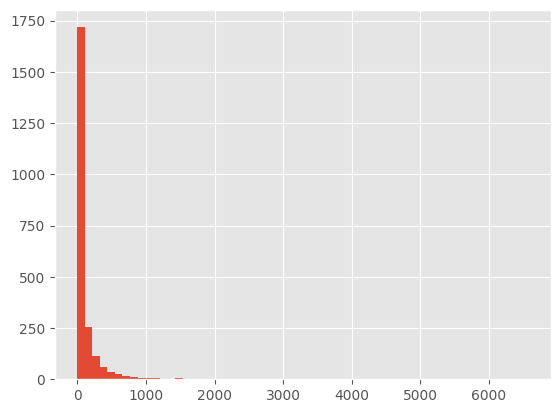

In [35]:
vacancies_frame["CountersTotalResponses"].hist(bins=60)

### Гистограмма по средним зарплатам

<Axes: >

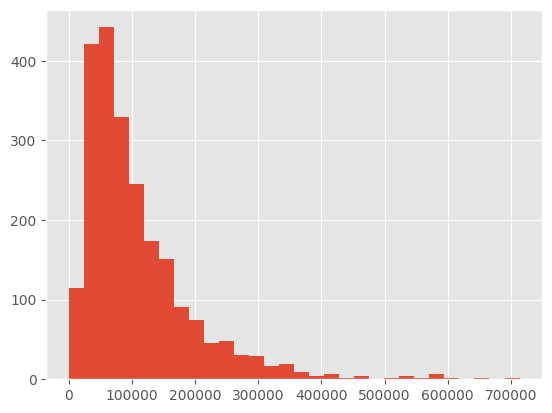

In [36]:
vacancies_frame["SalaryMiddleRub"].hist(bins=30)

# Математическая модель

In [37]:
# Необходимые импорты
#%pip install scikit-learn
#%pip install seaborn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns

## Модель соотношения общего количества откликов к заработной плате вакансии

### Определение модели

In [38]:
# Создание модели для соотношения общего количества откликов к заработной плате вакансии
X_responses = vacancies_frame[['SalaryMiddleRub']].values
y_responses = vacancies_frame['CountersTotalResponses'].values

model_responses = LinearRegression()
model_responses.fit(X_responses, y_responses)
y_pred_responses = model_responses.predict(X_responses)




### Оценка модели

In [39]:
mse_responses = mean_squared_error(y_responses, y_pred_responses)
r2_responses = r2_score(y_responses, y_pred_responses)
mae_responses = mean_absolute_error(y_responses, y_pred_responses)

### Вывод показателей

In [40]:
print(f'Mean Squared Error: {mse_responses}')
print(f'R^2 Score: {r2_responses}')
print(f'Mean Absolute Error: {mae_responses}')

Mean Squared Error: 82318.97379978492
R^2 Score: 0.0004916895629141216
Mean Absolute Error: 132.07281367960715


### Визуализация результатов

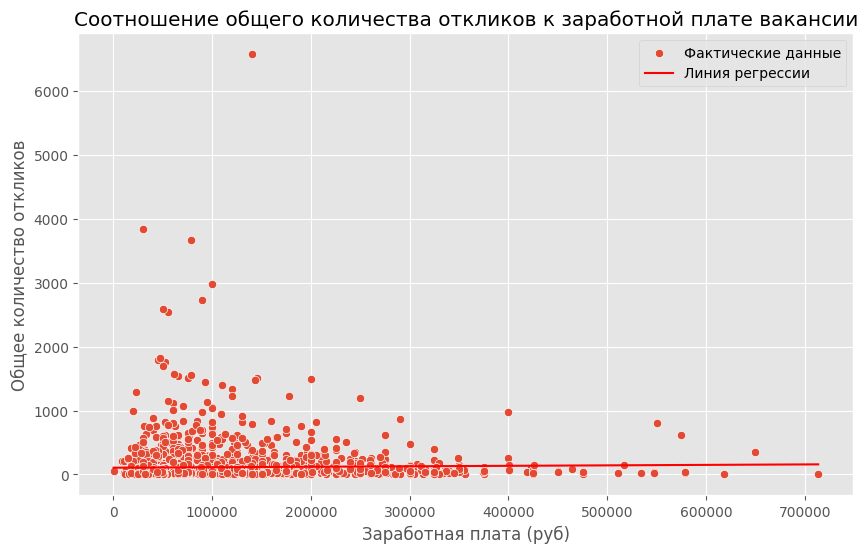

In [41]:
# Визуализация соотношения общего количества откликов к заработной плате вакансии
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_responses.flatten(), y=y_responses, label='Фактические данные')
sns.lineplot(x=X_responses.flatten(), y=y_pred_responses, color='red', label='Линия регрессии')
plt.xlabel('Заработная плата (руб)')
plt.ylabel('Общее количество откликов')
plt.title('Соотношение общего количества откликов к заработной плате вакансии')
plt.legend()
plt.show()

## Модель для соотношения заработной платы к опыту работы

### Подготовка данных

In [42]:
# Преобразование столбца ExperienceName в числовые значения
experience_mapping = {
    'Нет опыта': 0,
    'От 1 года до 3 лет': 1,
    'От 3 до 6 лет': 2,
    'Более 6 лет': 3
}
vacancies_frame['ExperienceNumeric'] = vacancies_frame['ExperienceName'].map(experience_mapping)

### Определение модели

In [43]:
X_experience = vacancies_frame[['ExperienceNumeric']].values
y_salary = vacancies_frame['SalaryMiddleRub'].values

model_experience = LinearRegression()
model_experience.fit(X_experience, y_salary)
y_pred_experience = model_experience.predict(X_experience)

### Оценка модели

In [44]:
mse_experience = mean_squared_error(y_salary, y_pred_experience)
r2_experience = r2_score(y_salary, y_pred_experience)
mae_experience = mean_absolute_error(y_salary, y_pred_experience)

### Вывод показателей

In [45]:
print(f'Experience - Mean Squared Error: {mse_experience}')
print(f'Experience - R^2 Score: {r2_experience}')
print(f'Mean Absolute Error: {mae_experience}')

Experience - Mean Squared Error: 5621460728.967377
Experience - R^2 Score: 0.25573298728769234
Mean Absolute Error: 52698.647655002766


### Визуализация результатов

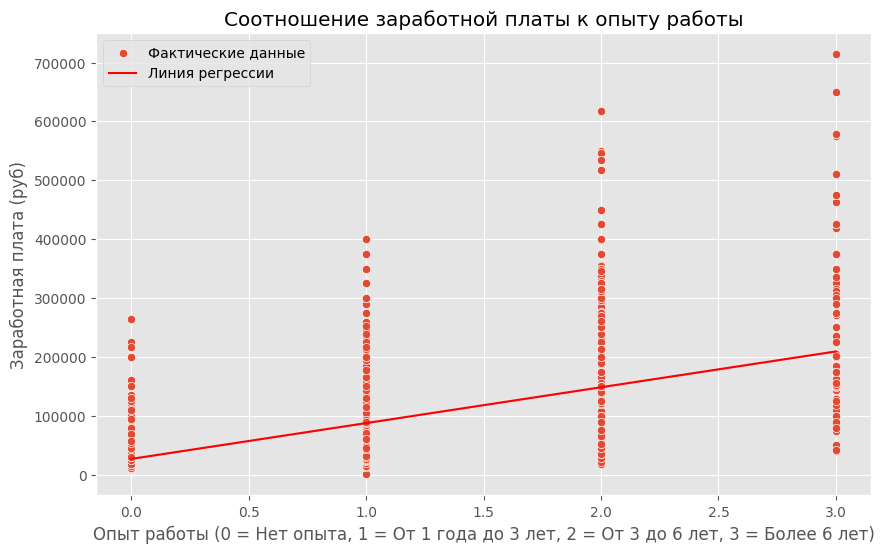

In [46]:
# Визуализация соотношения заработной платы к опыту работы
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_experience.flatten(), y=y_salary, label='Фактические данные')
sns.lineplot(x=X_experience.flatten(), y=y_pred_experience, color='red', label='Линия регрессии')
plt.xlabel('Опыт работы (0 = Нет опыта, 1 = От 1 года до 3 лет, 2 = От 3 до 6 лет, 3 = Более 6 лет)')
plt.ylabel('Заработная плата (руб)')
plt.title('Соотношение заработной платы к опыту работы')
plt.legend()
plt.show()

## Модель для описания соотношения количества ключевых навыков к заработной плате

### Подготовка данных

In [47]:
# Пост-фактум очистка строк с пустыми значениями в столбце KeySkills
vacancies_frame.dropna(subset=['KeySkills'], inplace=True)
# Подсчет количества ключевых навыков
vacancies_frame['KeySkillsCount'] = vacancies_frame['KeySkills'].apply(lambda x: len(x.split(',')))

### Определение модели

In [48]:
# Создание модели для соотношения заработной платы к количеству ключевых навыков
X_skills = vacancies_frame[['KeySkillsCount']].values
y_salary_skills = vacancies_frame['SalaryMiddleRub'].values

model_skills = LinearRegression()
model_skills.fit(X_skills, y_salary_skills)
y_pred_skills = model_skills.predict(X_skills)

### Оценка модели 

In [49]:
mse_skills = mean_squared_error(y_salary_skills, y_pred_skills)
r2_skills = r2_score(y_salary_skills, y_pred_skills)
mae_skills =  mean_absolute_error(y_salary_skills, y_pred_skills)

### Вывод показателей

In [50]:
print(f'Skills - Mean Squared Error: {mse_skills}')
print(f'Skills - R^2 Score: {r2_skills}')
print(f'Mean Absolute Error: {mae_skills}')

Skills - Mean Squared Error: 7886378671.962471
Skills - R^2 Score: 0.0020397389130668575
Mean Absolute Error: 63853.751111011785


### Визуализация результатов

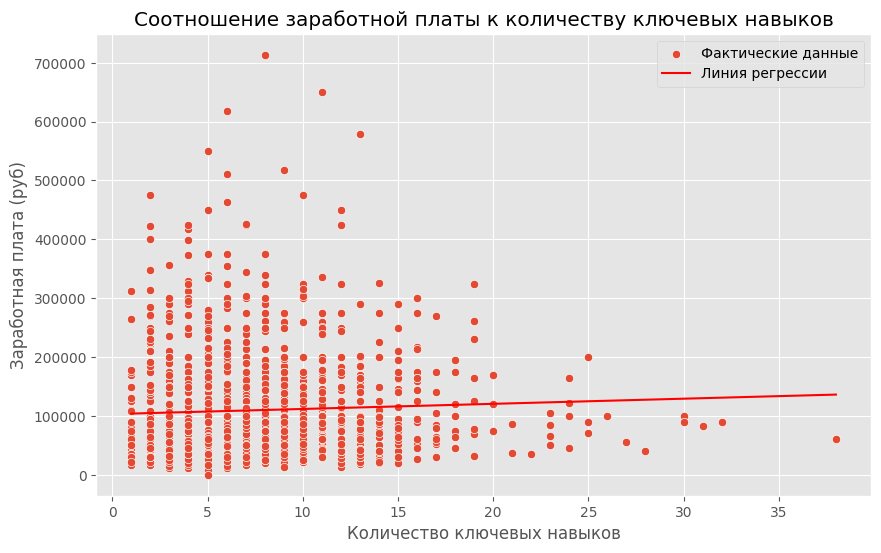

In [51]:
# Визуализация соотношения заработной платы к количеству ключевых навыков
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_skills.flatten(), y=y_salary_skills, label='Фактические данные')
sns.lineplot(x=X_skills.flatten(), y=y_pred_skills, color='red', label='Линия регрессии')
plt.xlabel('Количество ключевых навыков')
plt.ylabel('Заработная плата (руб)')
plt.title('Соотношение заработной платы к количеству ключевых навыков')
plt.legend()
plt.show()